# plots grid

/var/folders/m5/01zk54qj41sd7l141z41l6dw0000gn/T/ipykernel_8275/2121347074.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/m5/01zk54qj41sd7l141z41l6dw0000gn/T/ipykernel_8275/2121347074.py:255: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


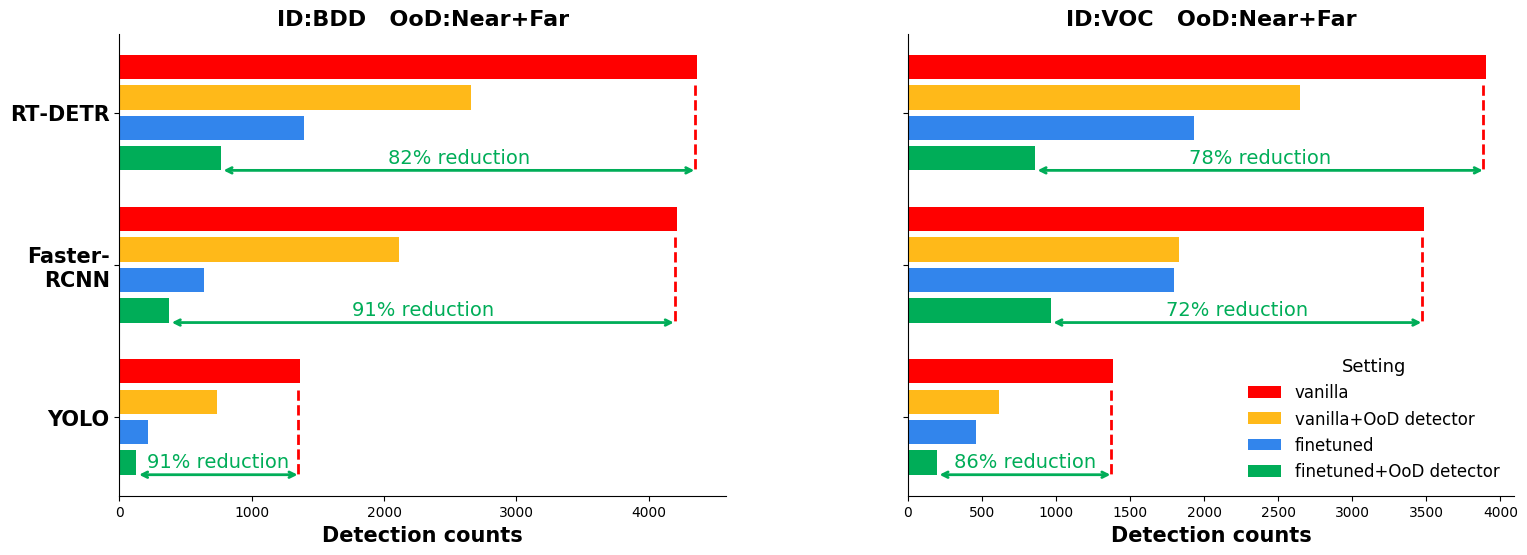

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ----------------------------------------------------------------------
# 1️⃣  Plot function – colour order changed
# ----------------------------------------------------------------------
def plot_detection_counts(id_dataset='bdd',
                          ood_type='far+near',
                          ax=None,
                          show_legend=True):
    """
    Plot detection counts for a given ID dataset and OoD type.

    Parameters
    ----------
    id_dataset : str
        'bdd' or 'voc'
    ood_type : str
        Only 'far+near' is used in the new grid (kept for backward compatibility).
    ax : matplotlib.axes.Axes, optional
        Axis to draw on.
    show_legend : bool, optional
        Whether to display the legend (default: True).
    """
    # -----------------------------------------------------------------
    # 2️⃣  Data (unchanged)
    # -----------------------------------------------------------------
    detection_counts = np.array([
        # YOLO
        [
            [  # BDD-100K
                [701, 363, 133, 80],    # Near-OoD
                [666, 371, 85, 47],     # Far-OoD
            ],
            [  # PASCAL-VOC
                [946, 443, 326, 134],   # Near-OoD
                [440, 174, 131, 60],    # Far-OoD
            ]
        ],
        # Faster R-CNN
        [
            [  # BDD-100K
                [2576, 1302, 394, 207], # Near-OoD
                [1634, 813, 242, 167],  # Far-OoD
            ],
            [  # PASCAL-VOC
                [2150, 1332, 1201, 710],# Near-OoD
                [1335, 501, 596, 253],  # Far-OoD
            ]
        ],
        # RT-DETR
        [
            [  # BDD-100K
                [3145, 1952, 967, 525], # Near-OoD
                [1220, 708, 426, 240],  # Far-OoD
            ],
            [  # PASCAL-VOC
                [2311, 1643, 964, 386], # Near-OoD
                [1589, 1001, 966, 470], # Far-OoD
            ]
        ]
    ])

    # -----------------------------------------------------------------
    # 3️⃣  Names, colour order, etc.
    # -----------------------------------------------------------------
    # Visual order: RT‑DETR → Faster‑RCNN → YOLO
    model_names = ['RT‑DETR', 'Faster-\nRCNN', 'YOLO']
    # Mapping from visual order to the original data order
    model_order = [2, 1, 0]          # 0→RT‑DETR, 1→Faster‑RCNN, 2→YOLO

    setting_names = ['vanilla', 'vanilla+OoD detector',
                     'finetuned', 'finetuned+OoD detector']
    # New colour order: red → yellow → blue → green
    colors = ['#FF0000',   # red
              '#FFB919',   # yellow (same as before for visual consistency)
              '#3285EC',   # blue
              '#00AD58']   # green

    # --------------------------------------------------------------
    # 4️⃣  Map inputs to indices (only Near+Far is needed)
    # --------------------------------------------------------------
    id_map = {'bdd': 0, 'voc': 1}
    if id_dataset.lower() not in id_map:
        raise ValueError("id_dataset must be 'bdd' or 'voc'")
    id_idx = id_map[id_dataset.lower()]

    # For the new grid we always want both Near and Far summed
    ood_indices = [0, 1]          # Near (0) + Far (1)
    ood_label   = 'Near+Far'

    # --------------------------------------------------------------
    # 5️⃣  Build the bar data (sum of Near and Far for each setting)
    # --------------------------------------------------------------
    bar_data = []
    for visual_m, data_m in enumerate(model_order):
        sums = np.zeros(4)
        for ood_i in ood_indices:
            sums += detection_counts[data_m, id_idx, ood_i]
        bar_data.append(sums)
    bar_data = np.array(bar_data)          # shape (3, 4)

    # --------------------------------------------------------------
    # 6️⃣  Reduction percentages (vanilla vs finetuned+OoD)
    # --------------------------------------------------------------
    reduction_percentages = []
    for m in range(3):
        vanilla = bar_data[m, 0]           # vanilla
        ftood   = bar_data[m, 3]           # finetuned+OoD detector
        reduction = (vanilla - ftood) / vanilla if vanilla != 0 else 0
        reduction_percentages.append(reduction)
    reduction_labels = [f'{p:.0%} reduction' for p in reduction_percentages]

    # --------------------------------------------------------------
    # 7️⃣  Plotting
    # --------------------------------------------------------------
    gap = 5
    y_pos = [m * gap + s for m in range(3) for s in range(4)]

    if ax is None:
        fig, ax = plt.subplots(figsize=(11, 6))
    else:
        fig = ax.figure

    ax.set_title(f'ID:{id_dataset.upper()}   OoD:{ood_label}',
                 fontsize=16, fontweight='bold')

    # Horizontal bars, grouped by model, coloured by setting
    for s, setting in enumerate(setting_names):
        for m, model in enumerate(model_names):
            idx = m * gap + s
            ax.barh(idx,
                    bar_data[m, s],
                    color=colors[s],
                    height=0.8,
                    label=setting if m == 0 else "")

    # Y‑ticks – only the model names, centred in each group
    y_ticks = [m * gap + 1.5 for m in range(3)]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(model_names, fontsize=15, fontweight='bold')
    ax.set_xlabel('Detection counts',fontsize=15, fontweight='bold')
    ax.invert_yaxis()                     # top‑to‑bottom ordering

    # --------------------------------------------------------------
    # 8️⃣  Legend (lower‑right, no rectangle) – drawn only when requested
    # --------------------------------------------------------------
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(),
                  by_label.keys(),
                  title='Setting',
                  fontsize=12,
                  title_fontsize=13,
                  loc='lower right',
                  frameon=False)

    # --------------------------------------------------------------
    # 9️⃣  Arrow + reduction text for each architecture
    # --------------------------------------------------------------
    for m in range(3):
    # ----  existing values -------------------------------------------------
        x0 = bar_data[m, 0]          # vanilla count (left side of green arrow)
        x1 = bar_data[m, 3]          # finetuned+OoD count (right side of green arrow)
        y_arrow = m * gap + 3 + 0.4   # y‑position where the green arrow lives

        # ----  GREEN arrow ------------------------------------------------------
        ax.annotate(
            '',
            xy=(x1, y_arrow), xytext=(x0, y_arrow),
            arrowprops=dict(
                arrowstyle='<->',
                color='#00AD58',      # green
                lw=2)
        )

        # ----  GREEN reduction text ---------------------------------------------
        ax.text(
            (x0 + x1) / 2,
            y_arrow - 0.1,
            reduction_labels[m],
            color='#00AD58',          # green
            fontsize=14,
            ha='center',
            va='bottom')
        
        # -----------------------------------------------------------------------
        #  🔴  RED dashed connector line (new!)
        # -----------------------------------------------------------------------
        # 1️⃣  X‑coordinate of the *right‑most* tip of the red bar (finetuned)
        #     The red bar is the second column in `bar_data` → index 1.
        x_red = bar_data[m, 0]

        # 2️⃣  Y‑coordinate of the centre of that red bar.
        #     Bars are plotted at integer offsets inside each group:
        #         vanilla      → y = m*gap + 0
        #         **finetuned** → y = m*gap + 1   ← red bar
        #         finetuned+OoD→ y = m*gap + 2
        #     The height of a bar is `bar_width` (default 0.8).  The centre is
        #     therefore exactly the y‑value we used when we called `ax.barh`.
        y_red = m * gap

        # 3️⃣  Draw the red dashed line from (x_red, y_red) → (x1, y_arrow)
        ax.plot(
            [x_red-15, x_red-15],               # X‑coordinates (start → end)
            [y_red+0.6, y_arrow],          # Y‑coordinates (start → end)
            color='red',               # line colour
            linestyle='--',            # dashed style
            linewidth=2,               # a little thicker so it's visible
            zorder=5)            
        # --------------------------------------------------------------
        # 10️⃣  Aesthetic tweaks
        # --------------------------------------------------------------
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    return fig, ax


# ----------------------------------------------------------------------
# 11️⃣  Grid creator – legend now appears on the VOC subplot
# ----------------------------------------------------------------------
def plot_detection_counts_grid_near_plus_far():
    """
    Produce a 1‑row, 2‑column figure:
        • column‑0 → ID = BDD‑100K (no legend)
        • column‑1 → ID = PASCAL‑VOC (legend in lower‑right corner)
    Both columns show the Near + Far (far+near) results.
    """
    from IPython.display import display

    fig = plt.figure(figsize=(18, 6))
    gs = GridSpec(1, 2, figure=fig, wspace=0.3, hspace=0.2)

    # ---- Left panel – BDD‑100K (legend hidden) --------------------
    ax0 = fig.add_subplot(gs[0, 0])
    plot_detection_counts(id_dataset='bdd',
                          ood_type='far+near',
                          ax=ax0,
                          show_legend=False)

    # ---- Right panel – PASCAL‑VOC (legend shown) -----------------
    ax1 = fig.add_subplot(gs[0, 1])
    plot_detection_counts(id_dataset='voc',
                          ood_type='far+near',
                          ax=ax1,
                          show_legend=True)   # legend appears here

    # Remove y‑tick labels on the right panel so the two columns line up nicely
    ax1.set_yticklabels([])

    plt.tight_layout()
    
    # Save figure to PDF
    plt.savefig('detection_counts_grid.pdf', bbox_inches='tight')
    
    display(fig)
    plt.close(fig)


# ----------------------------------------------------------------------
# Run the updated grid
# ----------------------------------------------------------------------
plot_detection_counts_grid_near_plus_far()


# individual plots for BDD

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_detection_counts(id_dataset='bdd', ood_type='far+near'):
    """
    Plot detection counts for a given ID dataset and OoD type.

    Args:
        id_dataset (str): 'bdd' or 'voc'
        ood_type (str): 'far+near', 'far', or 'near'
    """
    # Data: [model][dataset][ood_type][setting]
    detection_counts = np.array([
        # YOLO
        [
            [  # BDD-100K
                [708, 297, 145, 78],    # Near-OoD
                [641, 290, 136, 83],    # Far-OoD
            ],
            [  # PASCAL-VOC
                [991, 424, 364, 195],   # Near-OoD
                [431, 176, 140, 87],    # Far-OoD
            ]
        ],
        # Faster R-CNN
        [
            [  # BDD-100K
                [2595, 1272, 395, 270], # Near-OoD
                [1771, 903, 305, 145],  # Far-OoD
            ],
            [  # PASCAL-VOC
                [2330, 1594, 1321, 898],# Near-OoD
                [1400, 667, 639, 317],  # Far-OoD
            ]
        ],
        # RT-DETR
        [
            [  # BDD-100K
                [3209, 1669, 974, 537], # Near-OoD
                [1571, 829, 558, 341],  # Far-OoD
            ],
            [  # PASCAL-VOC
                [2529, 1600, 1153, 519],# Near-OoD
                [1719, 910, 984, 503],  # Far-OoD
            ]
        ]
    ])

    model_names = ['YOLO', 'Faster-\nRCNN', 'RT-DETR']
    setting_names = ['vanilla', 'vanilla+OoD detector', 'finetuned', 'finetuned+OoD detector']
    colors = ['#00AD58', '#FB2F74', '#FFB919', '#3285EC']

    # Map id_dataset to index
    id_map = {'bdd': 0, 'voc': 1}
    if id_dataset.lower() not in id_map:
        raise ValueError("id_dataset must be 'bdd' or 'voc'")
    id_idx = id_map[id_dataset.lower()]

    # Map ood_type to indices
    ood_type = ood_type.lower()
    if ood_type == 'far+near':
        ood_indices = [0, 1]
        ood_label = 'Near+Far'
    elif ood_type == 'far':
        ood_indices = [1]
        ood_label = 'Far'
    elif ood_type == 'near':
        ood_indices = [0]
        ood_label = 'Near'
    else:
        raise ValueError("ood_type must be 'far+near', 'far', or 'near'")

    # Prepare bar_data
    bar_data = []
    for model in range(3):
        sums = np.zeros(4)
        for ood_i in ood_indices:
            sums += detection_counts[model, id_idx, ood_i]
        bar_data.append(sums)
    bar_data = np.array(bar_data)  # shape: (3, 4)

    # --- Calculation of Reduction Percentages ---
    print(f"Calculating reduction percentages for {id_dataset.upper()} ({ood_label} OoD):")
    reduction_percentages = []
    for m, model_name in enumerate(model_names):
        vanilla_count = bar_data[m, 0]  # 'vanilla' setting
        ftood_count = bar_data[m, 3]    # 'finetuned+OoD detector' setting
        reduction = (vanilla_count - ftood_count) / vanilla_count if vanilla_count != 0 else 0
        reduction_percentages.append(reduction)
        print(f"- {model_name}: (({vanilla_count} - {ftood_count}) / {vanilla_count}) * 100 = {reduction:.2%}")
    print("-" * 20)

    reduction_labels = [f'{p:.0%} reduction' for p in reduction_percentages]
    # --- End of Calculation ---

    gap = 5
    y_pos = []
    for m in range(3):
        for s in range(4):
            y_pos.append(m * gap + s)

    fig, ax = plt.subplots(figsize=(11, 6))
    ax.set_title(f'ID:{id_dataset.upper()}     OoD:{ood_label}', fontsize=16, fontweight='bold')

    # Draw horizontal bars, grouped by model, colored by setting
    for s, setting in enumerate(setting_names):
        for m, model in enumerate(model_names):
            idx = m * gap + s
            ax.barh(idx, bar_data[m, s], color=colors[s], height=0.8, label=setting if m == 0 else "")

    # Only show architecture names as yticks, centered in each group
    y_ticks = [m * gap + 1.5 for m in range(3)]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(model_names, fontsize=15, fontweight='bold')
    ax.set_xlabel('Detection counts', fontsize=14)
    ax.invert_yaxis()  # Top-to-bottom like your draft

    # Remove minor yticks (individual bars)
    ax.tick_params(axis='y', which='minor', left=False)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Setting', fontsize=12, title_fontsize=13, loc='upper right')

    # Highlight reduction (vanilla vs finetuned+OoD detector) for all three architectures
    for m in range(3):
        y_vanilla = m * gap + 0  # vanilla bar y position
        y_ftood = m * gap + 3    # finetuned+OoD detector bar y position
        x0 = bar_data[m, 0]
        x1 = bar_data[m, 3]
        # Place the arrow aligned with the bottom of the last bar.
        # Bar center is at y_ftood, bar height is 0.8, so bottom edge is at y_ftood + 0.4.
        y_arrow = y_ftood + 0.4
        ax.annotate('', xy=(x1, y_arrow), xytext=(x0, y_arrow),
                    arrowprops=dict(arrowstyle='<->', color='#F28E2B', lw=2))
        # Place text slightly above the arrow for better visibility
        ax.text((x0 + x1) / 2, y_arrow - 0.1, reduction_labels[m], color='#F28E2B', fontsize=14, ha='center', va='bottom')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

Calculating reduction percentages for BDD (Near+Far OoD):
- YOLO: ((1349.0 - 161.0) / 1349.0) * 100 = 88.07%
- Faster-
RCNN: ((4366.0 - 415.0) / 4366.0) * 100 = 90.49%
- RT-DETR: ((4780.0 - 878.0) / 4780.0) * 100 = 81.63%
--------------------


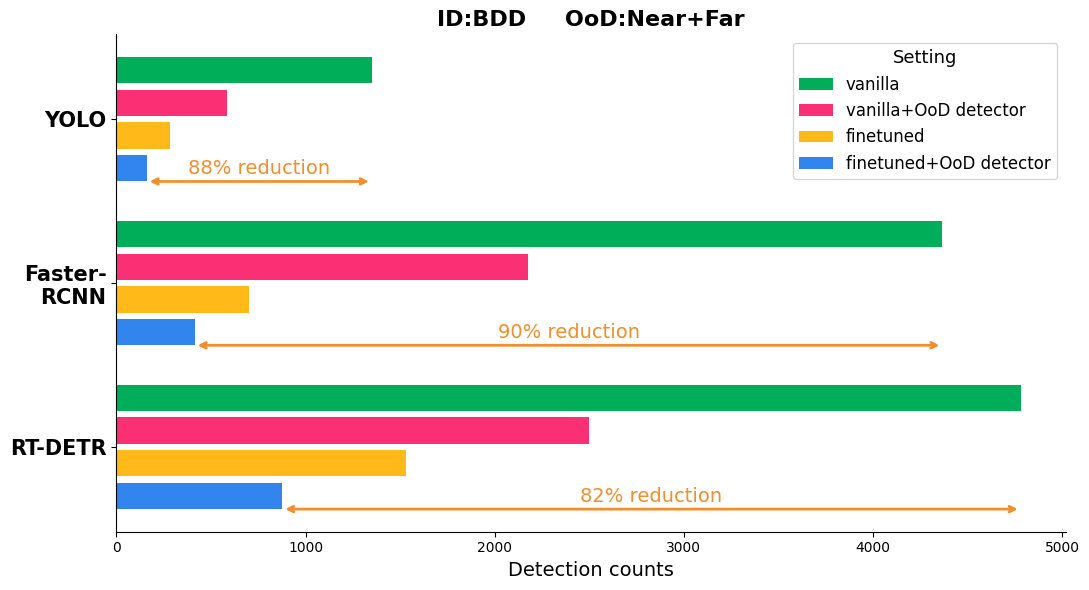

In [26]:
plot_detection_counts('bdd', 'far+near')

Calculating reduction percentages for BDD (Far OoD):
- YOLO: ((641.0 - 83.0) / 641.0) * 100 = 87.05%
- Faster-
RCNN: ((1771.0 - 145.0) / 1771.0) * 100 = 91.81%
- RT-DETR: ((1571.0 - 341.0) / 1571.0) * 100 = 78.29%
--------------------


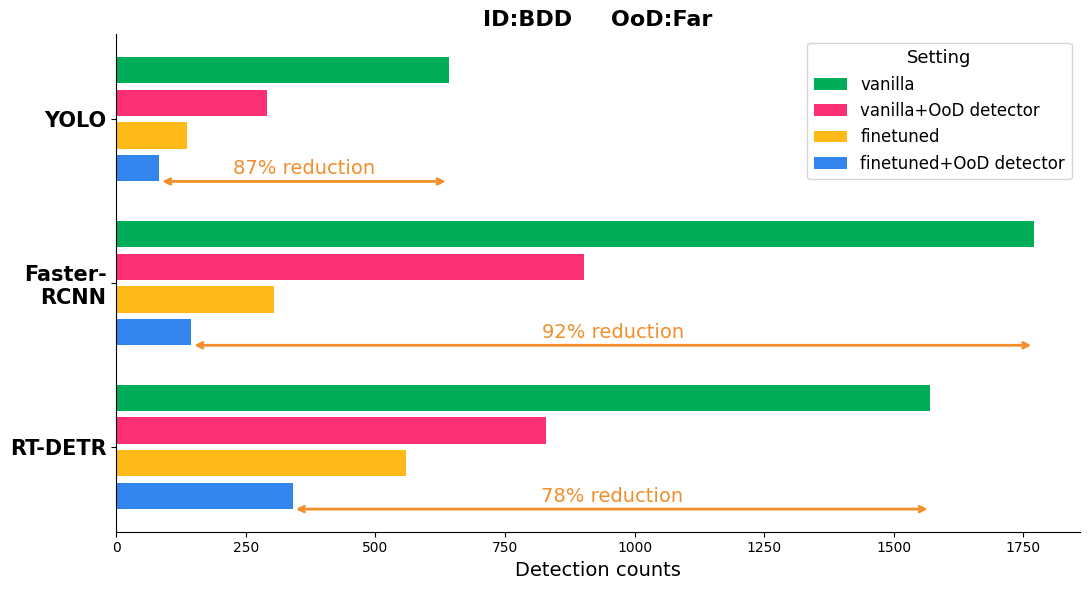

In [27]:
plot_detection_counts('bdd', 'far')

Calculating reduction percentages for BDD (Near OoD):
- YOLO: ((708.0 - 78.0) / 708.0) * 100 = 88.98%
- Faster-
RCNN: ((2595.0 - 270.0) / 2595.0) * 100 = 89.60%
- RT-DETR: ((3209.0 - 537.0) / 3209.0) * 100 = 83.27%
--------------------


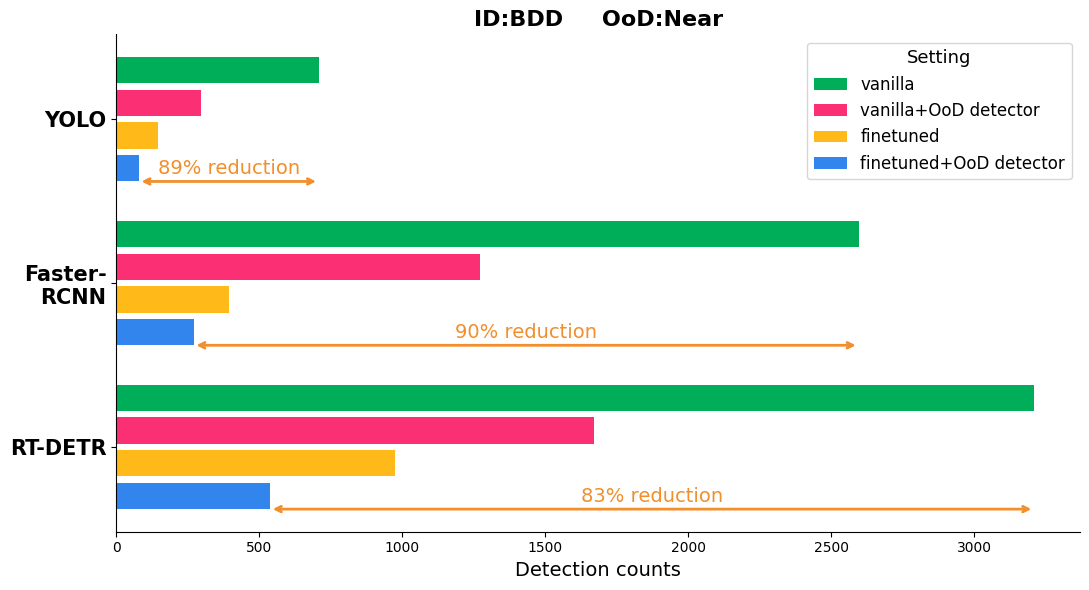

In [28]:
plot_detection_counts('bdd', 'near')

# individual plots for VOC

Calculating reduction percentages for VOC (Near+Far OoD):
- YOLO: ((1422.0 - 282.0) / 1422.0) * 100 = 80.17%
- Faster-
RCNN: ((3730.0 - 1215.0) / 3730.0) * 100 = 67.43%
- RT-DETR: ((4248.0 - 1022.0) / 4248.0) * 100 = 75.94%
--------------------


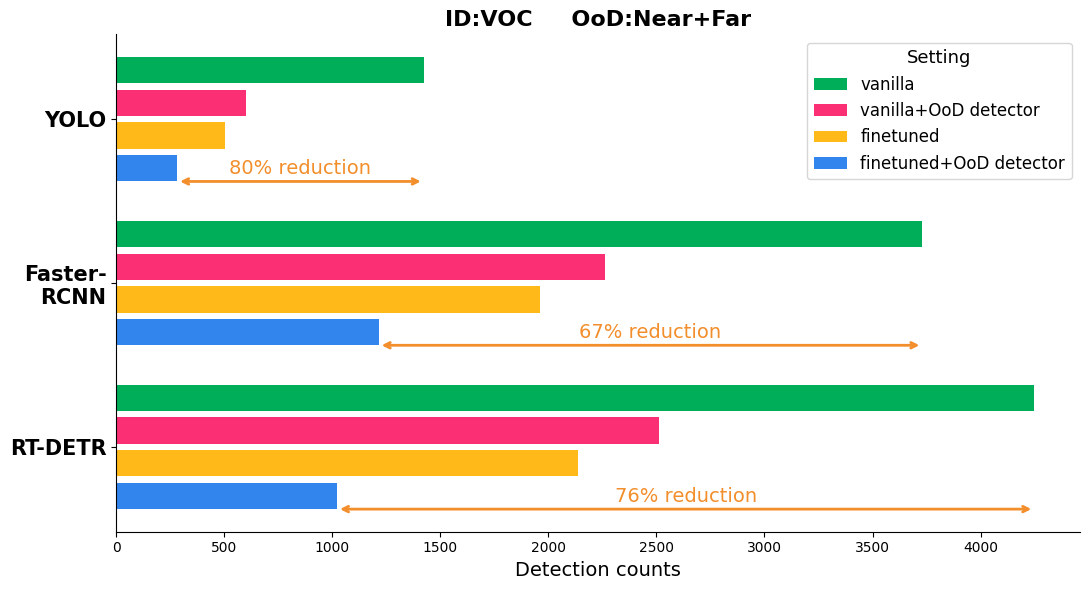

In [29]:
plot_detection_counts('voc', 'far+near')

Calculating reduction percentages for VOC (Far OoD):
- YOLO: ((431.0 - 87.0) / 431.0) * 100 = 79.81%
- Faster-
RCNN: ((1400.0 - 317.0) / 1400.0) * 100 = 77.36%
- RT-DETR: ((1719.0 - 503.0) / 1719.0) * 100 = 70.74%
--------------------


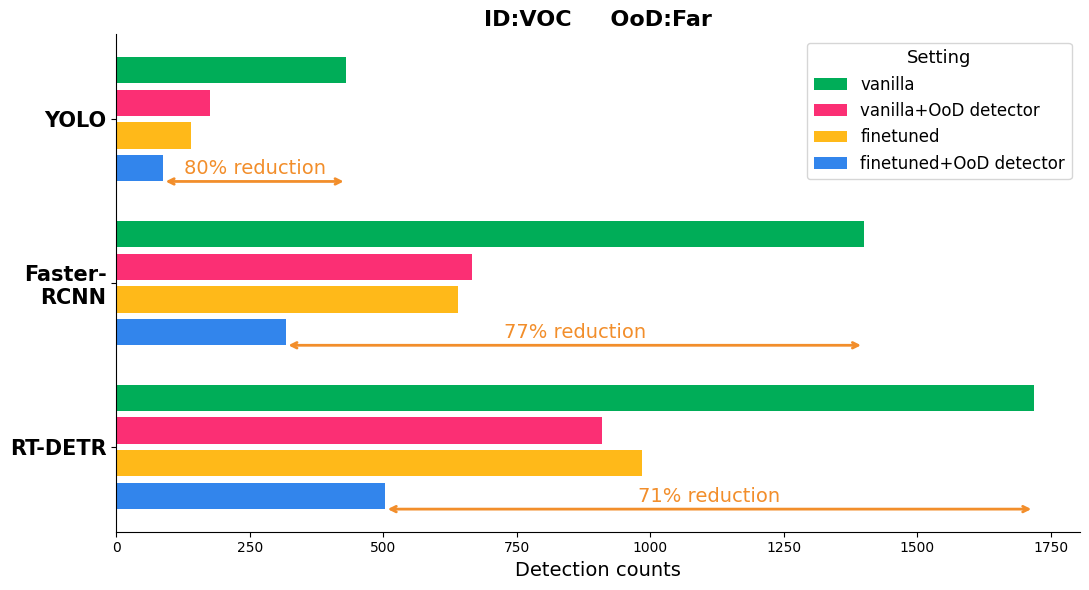

In [30]:
plot_detection_counts('voc', 'far')

Calculating reduction percentages for VOC (Near OoD):
- YOLO: ((991.0 - 195.0) / 991.0) * 100 = 80.32%
- Faster-
RCNN: ((2330.0 - 898.0) / 2330.0) * 100 = 61.46%
- RT-DETR: ((2529.0 - 519.0) / 2529.0) * 100 = 79.48%
--------------------


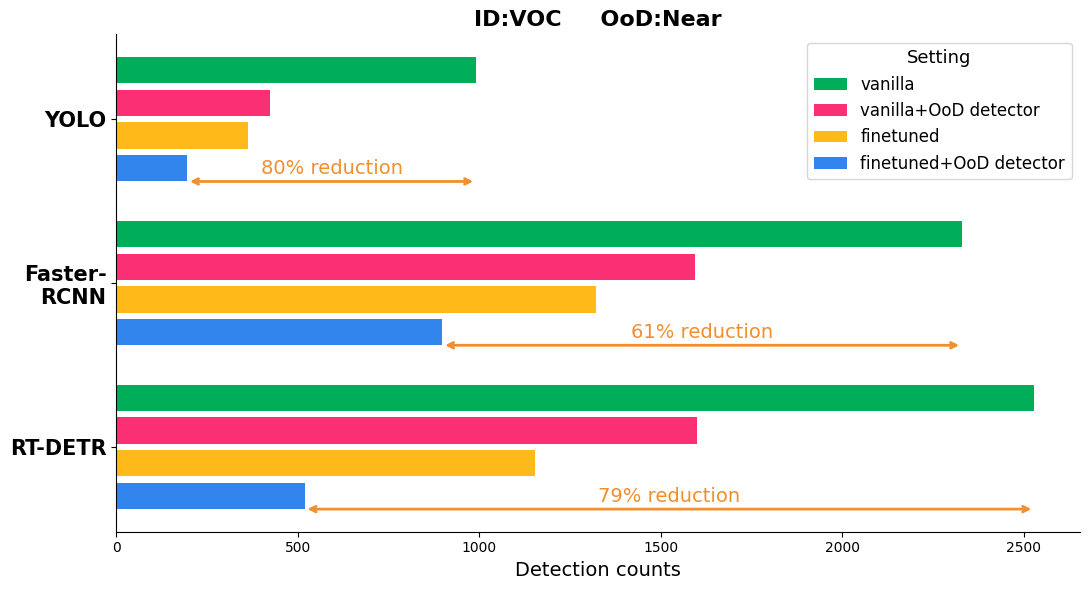

In [31]:
plot_detection_counts('voc', 'near')